In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from common import data
from common.training import training_loop, get_predictions

from algos import stoc
from algos import cbl

from common.models import simple_conv
from common import metrics
from common.models.modutils import load_model


c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [11]:
log_dir = "./outs/stoc_k3_gamma_2"

horizon = 1024
stride = 512 + 128

batch_size = 8

num_epochs = [1, 2, 5, 10, 20, 50, 100, 500]
out_feats = 64
k = 3
gamma = 0.05

learning_rate = 1e-2

weight_decay = 1e-1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [12]:
"""
../data/r216n09.gzip - 16388 timesteps - 3.76% anomalies - len seq anomal 4.9
../data/r229n10.gzip - 13239 timesteps - 4.21% anomalies - len seq anomal 4.6
../data/r233n14.gzip - 15384 timesteps - 3.66% anomalies - len seq anomal 4.8
../data/r245n15.gzip - 14874 timesteps - 4.04% anomalies - len seq anomal 4.7
"""
train = ["../data/r216n09.gzip", "../data/r229n10.gzip", "../data/r245n15.gzip"]
test = ["../data/r233n14.gzip"]
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


In [13]:
train_dataset = data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride)
test_dataset = data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride)

print(len(train_dataset), len(test_dataset))

70 24


In [14]:
base_width = 128
down_layers = 3
dilations = [False, True, True]

backbone = simple_conv.Encoder(data.NUM_FEATURES, down_layers, base_width, dilations)
model = simple_conv.SimpleConv(backbone, out_feats, horizon)

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, sum(num_epochs))

aug = cbl.pipeline(
    cbl.random_apply(cbl.left_to_right_flipping(1), 0.5),
    cbl.random_apply(cbl.crop_and_resize(1.5, 3), 0.8),
)

engine = cbl.CBLEngine(
    model=model,
    optimizer=optim,
    temperature=0.5,
    aug_1=aug,
    aug_2=aug,
    lr_scheduler=lr_sched,
    device=device,
)

stoc_engine = stoc.STOC(engine, gamma)


In [15]:
with SummaryWriter(log_dir + "/logs") as writer:
    stoc_engine.fit(
        train_dataset,
        test_dataset,
        batch_size,
        k,
        num_epochs,
        writer=writer,
        save_path=log_dir + "/models",
    )


# stoc_engine.fit(train_dataset, test_dataset, batch_size, k, num_epochs)

Iteration 0 - Epoch 0 - train_loss=2.023 - test_loss=2.358 - lr=1.00e-02


Iteration 1 - Epoch 0 - train_loss=1.933 - test_loss=2.259 - lr=1.00e-02


Iteration 1 - Epoch 1 - train_loss=1.844 - test_loss=2.435 - lr=1.00e-02


Iteration 2 - Epoch 0 - train_loss=1.797 - test_loss=2.367 - lr=1.00e-02


Iteration 2 - Epoch 1 - train_loss=1.773 - test_loss=2.240 - lr=1.00e-02


Iteration 2 - Epoch 2 - train_loss=1.746 - test_loss=2.296 - lr=1.00e-02


Iteration 2 - Epoch 3 - train_loss=1.547 - test_loss=2.211 - lr=1.00e-02


Iteration 2 - Epoch 4 - train_loss=1.524 - test_loss=2.101 - lr=1.00e-02


Iteration 3 - Epoch 0 - train_loss=1.431 - test_loss=2.007 - lr=1.00e-02


Iteration 3 - Epoch 1 - train_loss=1.458 - test_loss=2.064 - lr=1.00e-02


Iteration 3 - Epoch 2 - train_loss=1.449 - test_loss=2.162 - lr=9.99e-03


Iteration 3 - Epoch 3 - train_loss=1.404 - test_loss=2.107 - lr=9.99e-03


Iteration 3 - Epoch 4 - train_loss=1.519 - test_loss=1.979 - lr=9.99e-03


Iteration 3 - Epoch 5 - train_loss=1.477 - test_loss=2.146 - lr=9.99e-03


Iteration 3 - Epoch 6 - train_loss=1.463 - test_loss=2.190 - lr=9.99e-03


Iteration 3 - Epoch 7 - train_loss=1.454 - test_loss=2.007 - lr=9.99e-03


Iteration 3 - Epoch 8 - train_loss=1.550 - test_loss=2.083 - lr=9.99e-03


Iteration 3 - Epoch 9 - train_loss=1.458 - test_loss=2.175 - lr=9.98e-03


Iteration 4 - Epoch 0 - train_loss=1.379 - test_loss=1.894 - lr=9.98e-03


Iteration 4 - Epoch 1 - train_loss=1.379 - test_loss=2.013 - lr=9.98e-03


Iteration 4 - Epoch 2 - train_loss=1.384 - test_loss=2.019 - lr=9.98e-03


Iteration 4 - Epoch 3 - train_loss=1.349 - test_loss=1.953 - lr=9.98e-03


Iteration 4 - Epoch 4 - train_loss=1.319 - test_loss=1.983 - lr=9.97e-03


Iteration 4 - Epoch 5 - train_loss=1.536 - test_loss=2.065 - lr=9.97e-03


Iteration 4 - Epoch 6 - train_loss=1.392 - test_loss=2.066 - lr=9.97e-03


Iteration 4 - Epoch 7 - train_loss=1.431 - test_loss=2.163 - lr=9.97e-03


Iteration 4 - Epoch 8 - train_loss=1.414 - test_loss=2.017 - lr=9.96e-03


Iteration 4 - Epoch 9 - train_loss=1.343 - test_loss=1.992 - lr=9.96e-03


Iteration 4 - Epoch 10 - train_loss=1.361 - test_loss=2.059 - lr=9.96e-03


Iteration 4 - Epoch 11 - train_loss=1.319 - test_loss=2.140 - lr=9.96e-03


Iteration 4 - Epoch 12 - train_loss=1.340 - test_loss=1.929 - lr=9.95e-03


Iteration 4 - Epoch 13 - train_loss=1.389 - test_loss=2.100 - lr=9.95e-03


Iteration 4 - Epoch 14 - train_loss=1.281 - test_loss=2.125 - lr=9.95e-03


Iteration 4 - Epoch 15 - train_loss=1.239 - test_loss=2.002 - lr=9.94e-03


Iteration 4 - Epoch 16 - train_loss=1.232 - test_loss=2.127 - lr=9.94e-03


Iteration 4 - Epoch 17 - train_loss=1.320 - test_loss=1.931 - lr=9.94e-03


Iteration 4 - Epoch 18 - train_loss=1.447 - test_loss=2.286 - lr=9.93e-03


Iteration 4 - Epoch 19 - train_loss=1.344 - test_loss=2.164 - lr=9.93e-03


Iteration 5 - Epoch 0 - train_loss=1.270 - test_loss=1.971 - lr=9.92e-03


Iteration 5 - Epoch 1 - train_loss=1.448 - test_loss=1.976 - lr=9.92e-03


Iteration 5 - Epoch 2 - train_loss=1.292 - test_loss=2.128 - lr=9.92e-03


Iteration 5 - Epoch 3 - train_loss=1.250 - test_loss=2.035 - lr=9.91e-03


Iteration 5 - Epoch 4 - train_loss=1.327 - test_loss=2.092 - lr=9.91e-03


Iteration 5 - Epoch 5 - train_loss=1.333 - test_loss=2.130 - lr=9.90e-03


Iteration 5 - Epoch 6 - train_loss=1.311 - test_loss=2.149 - lr=9.90e-03


Iteration 5 - Epoch 7 - train_loss=1.323 - test_loss=2.226 - lr=9.89e-03


Iteration 5 - Epoch 8 - train_loss=1.267 - test_loss=2.217 - lr=9.89e-03


Iteration 5 - Epoch 9 - train_loss=1.249 - test_loss=2.066 - lr=9.89e-03


Iteration 5 - Epoch 10 - train_loss=1.250 - test_loss=2.129 - lr=9.88e-03


Iteration 5 - Epoch 11 - train_loss=1.280 - test_loss=2.093 - lr=9.88e-03


Iteration 5 - Epoch 12 - train_loss=1.274 - test_loss=2.072 - lr=9.87e-03


Iteration 5 - Epoch 13 - train_loss=1.346 - test_loss=2.059 - lr=9.87e-03


Iteration 5 - Epoch 14 - train_loss=1.338 - test_loss=2.033 - lr=9.86e-03


Iteration 5 - Epoch 15 - train_loss=1.257 - test_loss=2.110 - lr=9.85e-03


Iteration 5 - Epoch 16 - train_loss=1.279 - test_loss=2.107 - lr=9.85e-03


Iteration 5 - Epoch 17 - train_loss=1.223 - test_loss=1.878 - lr=9.84e-03


Iteration 5 - Epoch 18 - train_loss=1.193 - test_loss=2.178 - lr=9.84e-03


Iteration 5 - Epoch 19 - train_loss=1.221 - test_loss=2.009 - lr=9.83e-03


Iteration 5 - Epoch 20 - train_loss=1.194 - test_loss=2.009 - lr=9.83e-03


Iteration 5 - Epoch 21 - train_loss=1.221 - test_loss=2.175 - lr=9.82e-03


Iteration 5 - Epoch 22 - train_loss=1.242 - test_loss=2.113 - lr=9.81e-03


Iteration 5 - Epoch 23 - train_loss=1.260 - test_loss=1.953 - lr=9.81e-03


Iteration 5 - Epoch 24 - train_loss=1.226 - test_loss=2.004 - lr=9.80e-03


Iteration 5 - Epoch 25 - train_loss=1.209 - test_loss=2.145 - lr=9.79e-03


Iteration 5 - Epoch 26 - train_loss=1.319 - test_loss=2.166 - lr=9.79e-03


Iteration 5 - Epoch 27 - train_loss=1.244 - test_loss=2.120 - lr=9.78e-03


Iteration 5 - Epoch 28 - train_loss=1.219 - test_loss=2.158 - lr=9.77e-03


Iteration 5 - Epoch 29 - train_loss=1.279 - test_loss=2.116 - lr=9.77e-03


Iteration 5 - Epoch 30 - train_loss=1.340 - test_loss=2.166 - lr=9.76e-03


Iteration 5 - Epoch 31 - train_loss=1.280 - test_loss=2.054 - lr=9.75e-03


Iteration 5 - Epoch 32 - train_loss=1.271 - test_loss=2.171 - lr=9.75e-03


Iteration 5 - Epoch 33 - train_loss=1.307 - test_loss=2.110 - lr=9.74e-03


Iteration 5 - Epoch 34 - train_loss=1.252 - test_loss=2.048 - lr=9.73e-03


Iteration 5 - Epoch 35 - train_loss=1.252 - test_loss=2.187 - lr=9.72e-03


Iteration 5 - Epoch 36 - train_loss=1.330 - test_loss=2.113 - lr=9.72e-03


Iteration 5 - Epoch 37 - train_loss=1.240 - test_loss=1.989 - lr=9.71e-03


Iteration 5 - Epoch 38 - train_loss=1.273 - test_loss=2.151 - lr=9.70e-03


Iteration 5 - Epoch 39 - train_loss=1.254 - test_loss=2.129 - lr=9.69e-03


Iteration 5 - Epoch 40 - train_loss=1.181 - test_loss=2.077 - lr=9.69e-03


Iteration 5 - Epoch 41 - train_loss=1.160 - test_loss=2.102 - lr=9.68e-03


Iteration 5 - Epoch 42 - train_loss=1.287 - test_loss=1.984 - lr=9.67e-03


Iteration 5 - Epoch 43 - train_loss=1.332 - test_loss=2.113 - lr=9.66e-03


Iteration 5 - Epoch 44 - train_loss=1.285 - test_loss=1.991 - lr=9.65e-03


Iteration 5 - Epoch 45 - train_loss=1.211 - test_loss=2.082 - lr=9.65e-03


Iteration 5 - Epoch 46 - train_loss=1.185 - test_loss=2.036 - lr=9.64e-03


Iteration 5 - Epoch 47 - train_loss=1.177 - test_loss=1.937 - lr=9.63e-03


Iteration 5 - Epoch 48 - train_loss=1.190 - test_loss=2.166 - lr=9.62e-03


Iteration 5 - Epoch 49 - train_loss=1.243 - test_loss=2.041 - lr=9.61e-03


Iteration 6 - Epoch 0 - train_loss=1.199 - test_loss=2.180 - lr=9.60e-03


Iteration 6 - Epoch 1 - train_loss=1.168 - test_loss=2.220 - lr=9.59e-03


Iteration 6 - Epoch 2 - train_loss=1.161 - test_loss=2.003 - lr=9.58e-03


Iteration 6 - Epoch 3 - train_loss=1.190 - test_loss=2.125 - lr=9.57e-03


Iteration 6 - Epoch 4 - train_loss=1.214 - test_loss=2.018 - lr=9.57e-03


KeyboardInterrupt: 

In [9]:
cmodel = metrics.default_cmodel()


In [26]:
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
scores, labels = get_predictions(stoc_engine.predict, test_loader)


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


In [27]:
cmodel.fit(scores, labels).optimize()


(-107.07819263457532, 0.31933594)

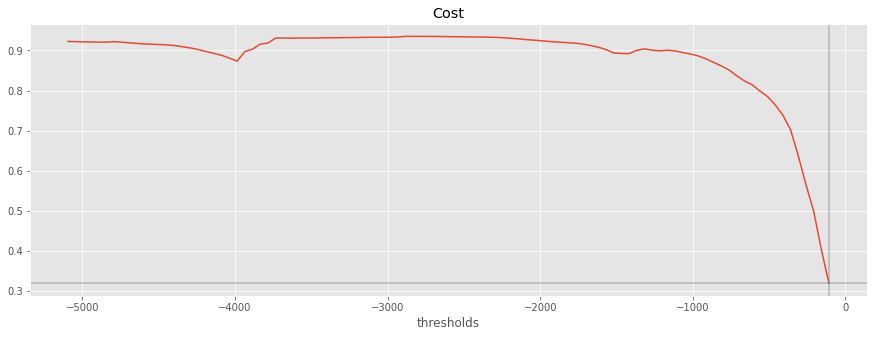

In [28]:
metrics.plot_cost(cmodel)


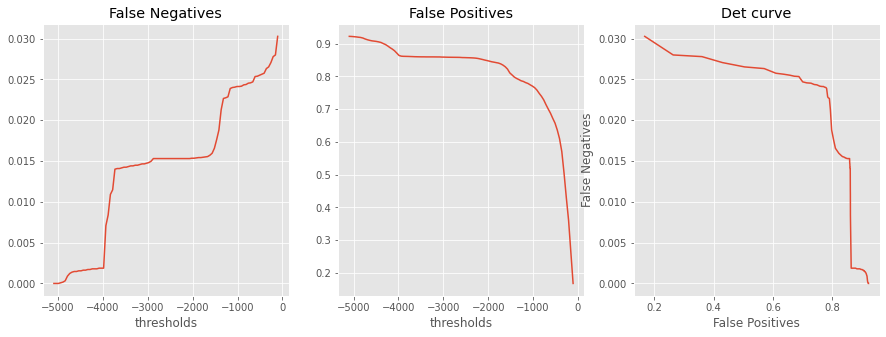

In [29]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


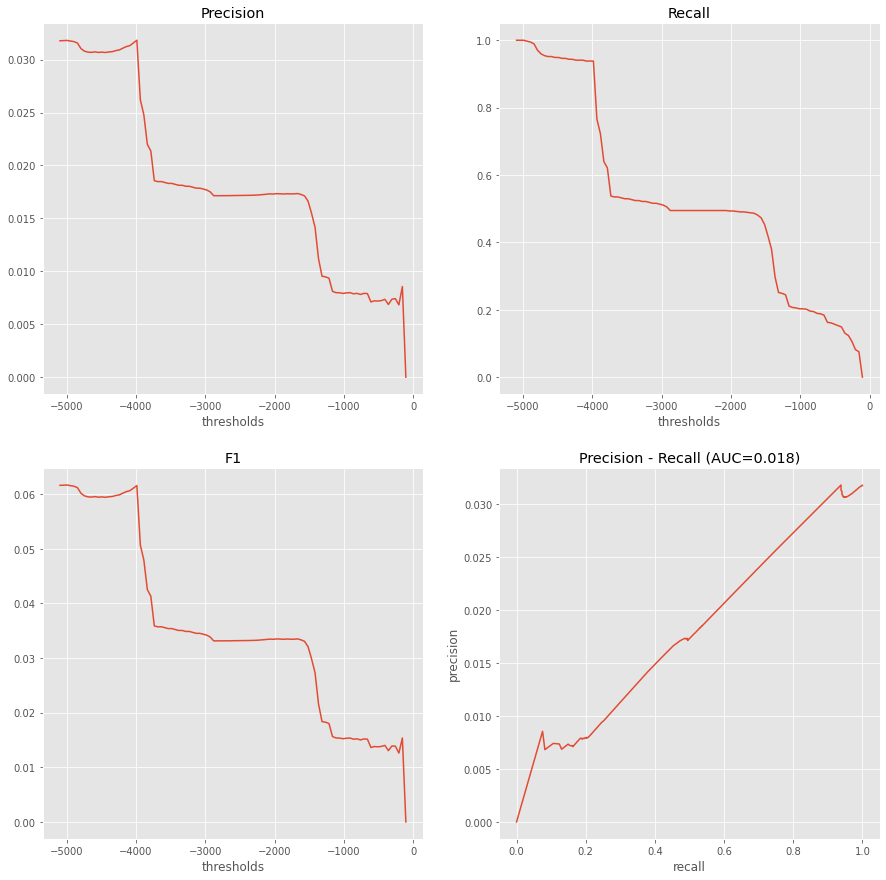

In [30]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)
